In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import linearmodels.panel as plm

/Users/christopher/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/christopher/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [12]:
final_merged_df = pd.read_csv('/Users/christopher/Desktop/Seminar-Advanced-Finance/finaldata.csv')

In [13]:
# Ensure that 'Date' is in datetime format
final_merged_df['Period End Date'] = pd.to_datetime(final_merged_df['Period End Date'], errors='coerce')

In [22]:
# Load your panel data
# Ensure it is a MultiIndex DataFrame with (firm, time)
df = final_merged_df.set_index(['Instrument', 'Period End Date'])

# Define dependent and independent variables
y = df['Log_TobinsQ']
X = df[['Debt Ratio', 'ROE', 'Asset Tangibility','Industry_Median_Leverage' ,'Size', 'DPR', 'Log_NetIncome_Shifted', 'GDP_Growth_pct', 'VIX_Growth', 'RnDintensity', 'PEratio', 'Interest Rate','EBITDA']]


# Add constant term for Random Effects model
X = sm.add_constant(X)

# Estimate Fixed Effects (Within Estimator)
fe_model = plm.PanelOLS(y, X, entity_effects=True).fit()

# Estimate Random Effects (GLS)
re_model = plm.RandomEffects(y, X).fit()

# Extract coefficients
beta_fe = fe_model.params
beta_re = re_model.params

# Compute covariance matrices
cov_fe = fe_model.cov
cov_re = re_model.cov

# Compute Hausman test statistic
beta_diff = beta_fe - beta_re
cov_diff = cov_fe - cov_re

# Invert covariance matrix (handle singularity issues)
try:
    chi2_stat = np.dot(np.dot(beta_diff.T, np.linalg.inv(cov_diff)), beta_diff)
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=X.shape[1])  # Degrees of freedom = number of regressors
except np.linalg.LinAlgError:
    chi2_stat, p_value = np.nan, np.nan
    print("⚠️ Covariance matrix is singular. Hausman test may not be valid.")

# Display results
print(f"📊 Hausman Test Statistic: {chi2_stat:.4f}")
print(f"📌 p-value: {p_value:.4f}")

# Decision Rule
if p_value < 0.05:
    print("✅ Reject H0: Fixed Effects (FE) is preferred!")
else:
    print("✅ Fail to Reject H0: Random Effects (RE) is preferred!")


/Users/christopher/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/Users/christopher/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


📊 Hausman Test Statistic: 65.4615
📌 p-value: 0.0000
✅ Reject H0: Fixed Effects (FE) is preferred!


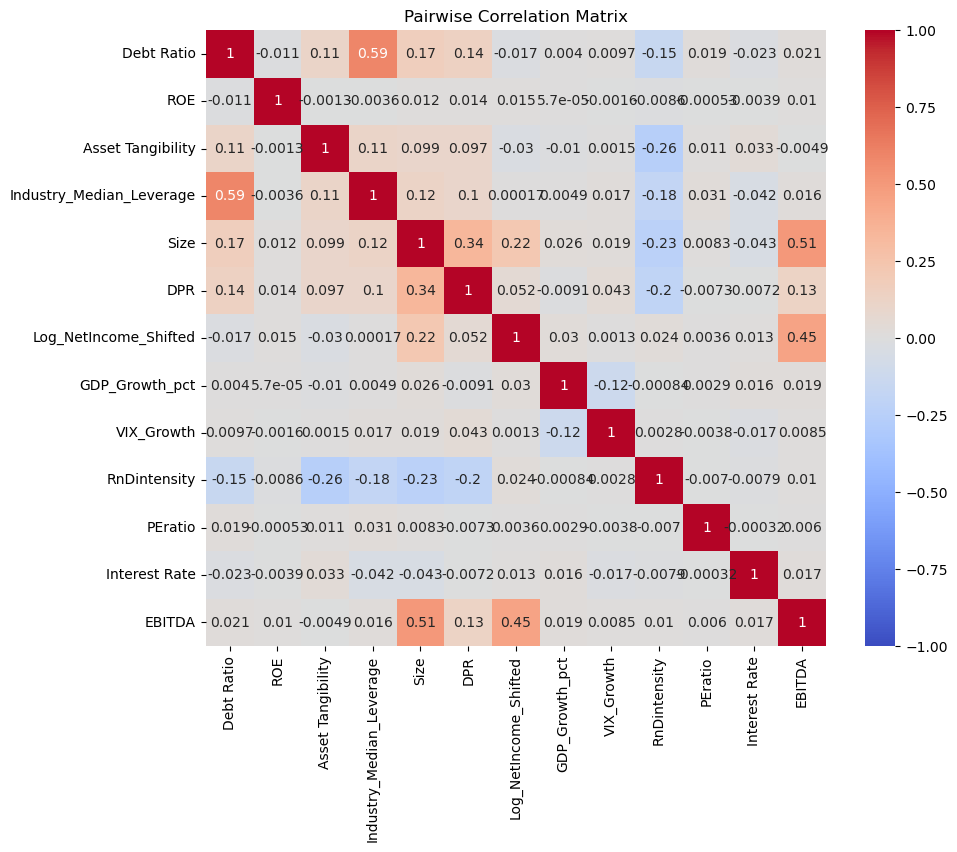

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

correl_data = X

if 'const' in correl_data.columns:
    correl_data = correl_data.drop(columns=['const'])

# Compute the pairwise correlation matrix
corr_matrix = correl_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise Correlation Matrix')
plt.show()

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Ensure df_numeric contains only the desired features
df_numeric = X.copy()

# Handle missing values by replacing them with the median for each column
df_numeric = df_numeric.fillna(df_numeric.median())

# Drop 'const' if it exists
if 'const' in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=['const'])

# Initialize dictionary to store VIF values
vif_manual = {}

# Calculate VIF manually for each feature
for feature in df_numeric.columns:
    # Define target variable (current feature) and predictor variables (all other features)
    y = df_numeric[feature]
    X = df_numeric.drop(columns=[feature])

    # Fit a linear regression model
    model = LinearRegression().fit(X, y)

    # Compute R-squared
    r_squared = model.score(X, y)

    # Avoid division by zero by setting a threshold
    vif = np.inf if r_squared >= 1.0 else 1 / (1 - r_squared)

    vif_manual[feature] = vif

# Convert VIF results to a DataFrame
vif_manual_df = pd.DataFrame(list(vif_manual.items()), columns=['Feature', 'VIF'])

# Sort by VIF value for better readability
vif_manual_df = vif_manual_df.sort_values(by="VIF", ascending=False)

# Display results
print(vif_manual_df)

                     Feature       VIF
12                    EBITDA  1.636087
4                       Size  1.584477
0                 Debt Ratio  1.565929
3   Industry_Median_Leverage  1.558444
6      Log_NetIncome_Shifted  1.259727
9               RnDintensity  1.158077
5                        DPR  1.125783
2          Asset Tangibility  1.062215
8                 VIX_Growth  1.017800
7             GDP_Growth_pct  1.017126
11             Interest Rate  1.007917
10                   PEratio  1.001090
1                        ROE  1.000658
